### Data Loading

In [6]:
# imports
import numpy as np
import matplotlib.pyplot as plt

from processing_utils.feature_data_from_mat import load_subject_high_gamma

Load in S14 Data

In [7]:
S14_hg_trace, S14_hg_map, S14_phon_labels = load_subject_high_gamma('S14', sig_channel=False, zscore=False)

(149, 200, 128)
(149, 8, 16, 200)
(149, 3)


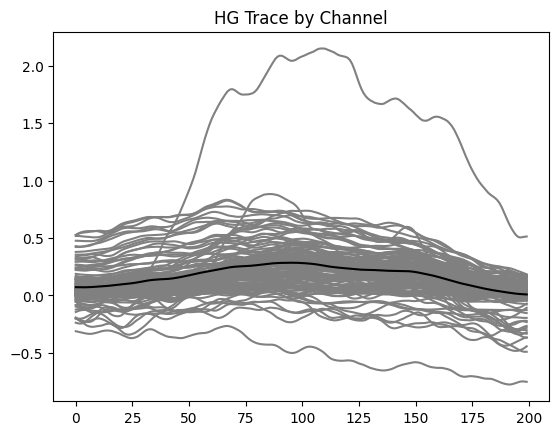

In [8]:
print(S14_hg_trace.shape)
print(S14_hg_map.shape)
print(S14_phon_labels.shape)

plt.figure()
plt.plot(np.mean(S14_hg_trace, axis=0), 'grey')
plt.plot(np.mean(np.mean(S14_hg_trace, axis=0), axis=1), 'black')
plt.title('HG Trace by Channel')
plt.show()

Load in S26 Data

In [9]:
S26_hg_trace, S26_hg_map, S26_phon_labels = load_subject_high_gamma('S26', sig_channel=False, zscore=False)

(152, 200, 128)
(152, 8, 16, 200)
(152, 3)


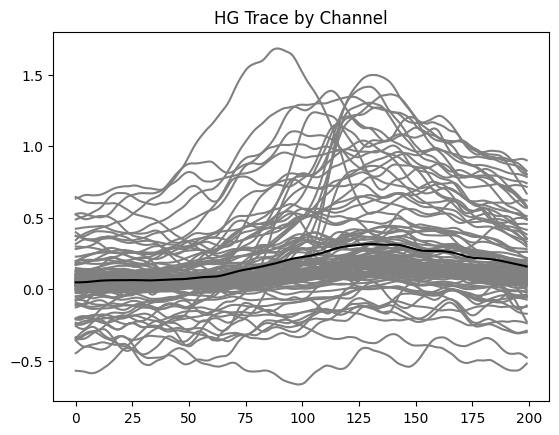

In [10]:
print(S26_hg_trace.shape)
print(S26_hg_map.shape)
print(S26_phon_labels.shape)

plt.figure()
plt.plot(np.mean(S26_hg_trace, axis=0), 'grey')
plt.plot(np.mean(np.mean(S26_hg_trace, axis=0), axis=1), 'black')
plt.title('HG Trace by Channel')
plt.show()

Load in S23 Data

In [11]:
S23_hg_trace, S23_hg_map, S23_phon_labels = load_subject_high_gamma('S23', sig_channel=False, zscore=False)

(153, 200, 128)
(153, 8, 16, 200)
(153, 3)


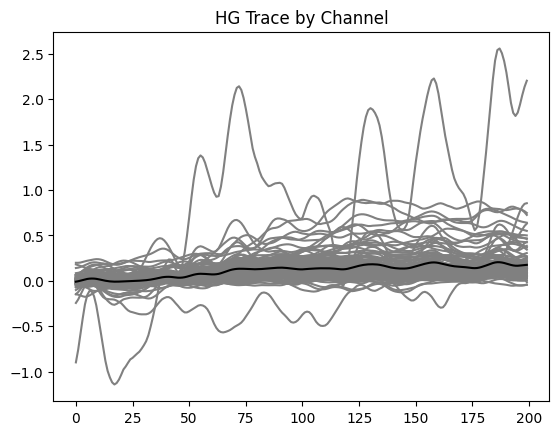

In [12]:
print(S23_hg_trace.shape)
print(S23_hg_map.shape)
print(S23_phon_labels.shape)

plt.figure()
plt.plot(np.mean(S23_hg_trace, axis=0), 'grey')
plt.plot(np.mean(np.mean(S23_hg_trace, axis=0), axis=1), 'black')
plt.title('HG Trace by Channel')
plt.show()

Load in S33 Data

In [13]:
S33_hg_trace, S33_hg_map, S33_phon_labels = load_subject_high_gamma('S33', sig_channel=False, zscore=False)

(52, 200, 256)
(52, 12, 24, 200)
(52, 3)


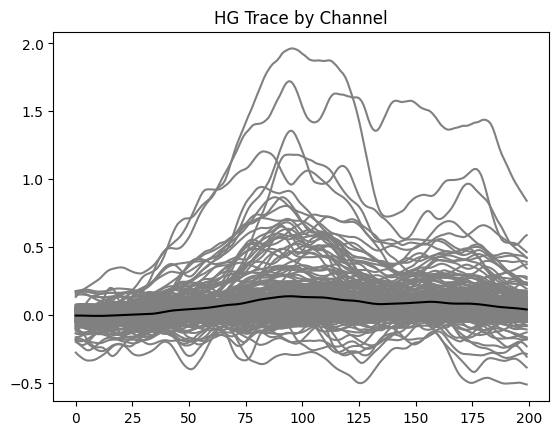

In [14]:
print(S33_hg_trace.shape)
print(S33_hg_map.shape)
print(S33_phon_labels.shape)

plt.figure()
plt.plot(np.mean(S33_hg_trace, axis=0), 'grey')
plt.plot(np.mean(np.mean(S33_hg_trace, axis=0), axis=1), 'black')
plt.title('HG Trace by Channel')
plt.show()

Process data for use with 1/3 D CNN Bidirectional LSTM seq2seq

In [16]:
# imports
from processing_utils.sequence_processing import pad_sequence_teacher_forcing

In [17]:
# parameters
n_output = 10

In [26]:
X1 = S14_hg_trace  # use HG traces (n_trials, n_channels, n_timepoints) for 1D CNN
# X1 = S14_hg_map  # use HG channel map stack (n_trials, n_channels_x, n_channels_y, n_timepoints) for 1D CNN
X1_prior, y1, prior1_labels, seq1_labels = pad_sequence_teacher_forcing(S14_phon_labels, n_output)  # first 2 outputs one-hot encoded

In [27]:
print(X1.shape, X1_prior.shape, y1.shape, prior1_labels.shape, seq1_labels.shape)

(149, 200, 128) (149, 3, 10) (149, 3, 10) (149, 3) (149, 3)


In [28]:
X2 = S26_hg_trace  # use HG traces (n_trials, n_channels, n_timepoints) for 1D CNN
# X2 = S26_hg_map  # use HG channel map stack (n_trials, n_channels_x, n_channels_y, n_timepoints) for 1D CNN
X2_prior, y2, prior2_labels, seq2_labels = pad_sequence_teacher_forcing(S26_phon_labels, n_output)  # first 2 outputs one-hot encoded

In [29]:
print(X2.shape, X2_prior.shape, y2.shape, prior2_labels.shape, seq2_labels.shape)

(152, 200, 128) (152, 3, 10) (152, 3, 10) (152, 3) (152, 3)


In [30]:
X2 = S23_hg_trace  # use HG traces (n_trials, n_channels, n_timepoints) for 1D CNN
# X2 = S23_hg_map  # use HG channel map stack (n_trials, n_channels_x, n_channels_y, n_timepoints) for 1D CNN
X2_prior, y2, prior2_labels, seq2_labels = pad_sequence_teacher_forcing(S23_phon_labels, n_output)  # first 2 outputs one-hot encoded

In [31]:
print(X2.shape, X2_prior.shape, y2.shape, prior2_labels.shape, seq2_labels.shape)

(153, 200, 128) (153, 3, 10) (153, 3, 10) (153, 3) (153, 3)


In [32]:
X2 = S33_hg_trace  # use HG traces (n_trials, n_channels, n_timepoints) for 1D CNN
# X2 = S33_hg_map  # use HG channel map stack (n_trials, n_channels_x, n_channels_y, n_timepoints) for 1D CNN
X2_prior, y2, prior2_labels, seq2_labels = pad_sequence_teacher_forcing(S33_phon_labels, n_output)  # first 2 outputs one-hot encoded

In [33]:
print(X2.shape, X2_prior.shape, y2.shape, prior2_labels.shape, seq2_labels.shape)

(52, 200, 256) (52, 3, 10) (52, 3, 10) (52, 3) (52, 3)


Build 1D CNN Bidirectional LSTM seq2seq Model

In [36]:
# imports
from seq2seq_models.rnn_models import (lstm_1Dcnn_model, gru_1Dcnn_model,
                                       lstm_3Dcnn_model, gru_3Dcnn_model)

In [42]:
# parameters

# 1D CNN
n_input_time = X1.shape[1]
n_input_channel = X1.shape[2]
filter_size = 10

# 3D CNN
# n_input_channel = [X1.shape[1], X1.shape[2]]
# n_input_time = X1.shape[3]
# filter_size = 2

n_filters = 100
n_units = 800
reg_lambda = 1e-6
dropout = 0.0
bidir = True

In [43]:
train_model, inf_enc, inf_dec = lstm_1Dcnn_model(n_input_time, n_input_channel, n_output, n_filters, filter_size, n_units, reg_lambda, bidir=bidir)

In [44]:
print(train_model.summary())
# print(train_model.layers[-1].summary())
# print(inf_enc.summary())
# print(inf_enc.layers[-1].summary())
# print(inf_dec.summary())

Model: "training_lstm_final"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 200, 128)]   0           []                               
                                                                                                  
 conv1d_3 (Conv1D)              (None, 20, 100)      128100      ['input_19[0][0]']               
                                                                                                  
 input_20 (InputLayer)          [(None, None, 10)]   0           []                               
                                                                                                  
 training_lstm_initial (Functio  (None, None, 10)    8369610     ['conv1d_3[0][0]',               
 nal)                                                             'input_20[0][0

### S26 Evaluation

In [ ]:
import time
from keras.optimizers import Adam
from train.train import train_seq2seq_kfold

In [ ]:
# parameters
num_folds = 10
num_reps = 1
batch_size = 200
epochs = 500
learning_rate = 5e-6

In [ ]:
train_model.compile(optimizer=Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
start = time.time()
histories, y_pred_all, y_test_all = train_seq2seq_kfold(train_model, inf_enc, inf_dec, X2, X2_prior, y2,
                                                        num_folds=num_folds, num_reps=num_reps,
                                                        batch_size=batch_size, epochs=epochs,
                                                        early_stop=False)
end = time.time()

In [ ]:
print(f'Time to train {num_folds} folds: {end-start} seconds')

In [ ]:
from visualization.plot_model_performance import extend_history_lists

histories = extend_history_lists(histories, epochs=epochs)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(np.array(histories['loss']).T, color='blue', alpha=0.35)
ax1.plot(np.mean(histories['loss'], axis=0), color='blue', label='Train')
ax1.plot(np.array(histories['val_loss']).T, color='orange', alpha=0.35)
ax1.plot(np.mean(histories['val_loss'], axis=0), color='orange', label='Test')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('RNN Loss')
ax1.legend()

ax2.plot(np.array(histories['accuracy']).T, color='blue', alpha=0.35)
ax2.plot(np.mean(histories['accuracy'], axis=0), color='blue', label='Train')
ax2.plot(np.array(histories['val_accuracy']).T, color='orange', alpha=0.35)
ax2.plot(np.mean(histories['val_accuracy'], axis=0), color='orange', label='Test')
# ax2.axhline(1/(n_output-1), color='gray', linestyle='--', label='Chance')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('RNN Accuracy')
ax2.legend()

plt.show()

In [ ]:
from sklearn.metrics import balanced_accuracy_score

print(f'Balanced Accuracy: {balanced_accuracy_score(y_test_all, y_pred_all)}')

In [ ]:
from visualization.plot_model_performance import plot_accuracy_loss

plot_accuracy_loss(histories, epochs=epochs)

### Transfer Training S14 -> S26

In [55]:
# imports
from keras.optimizers import Adam
from train.transfer_training import transfer_seq2seq_kfold

In [56]:
# trans_model, trans_enc, trans_dec = lstm_1Dcnn_model(n_input_time, n_input_channel, n_output, n_filters, filter_size, n_units, reg_lambda, bidir=bidir, dropout=dropout)
trans_model, trans_enc, trans_dec = lstm_3Dcnn_model(n_input_time, n_input_channel, n_output, n_filters, filter_size, n_units, reg_lambda, bidir=bidir, dropout=dropout)
# trans_model, trans_enc, trans_dec = gru_1Dcnn_model(n_input_time, n_input_channel, n_output, n_filters, filter_size, n_units, reg_lambda, bidir=bidir, dropout=dropout)

In [57]:
# parameters
num_folds = 5
batch_size = 200
epochs = 540
learning_rate = 1e-5

trans_model.compile(optimizer=Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

In [58]:
models, histories, y_pred_all, y_test_all = transfer_seq2seq_kfold(trans_model, trans_enc, trans_dec, X1, X1_prior, y1, X2, X2_prior, y2, num_folds=num_folds, fine_tune_epochs=epochs)

========== Fold 1 ==========
Epoch 1/200
1/1 [==============================] - 7s 7s/step - loss: 2.3486 - accuracy: 0.0291
Epoch 2/200
1/1 [==============================] - 3s 3s/step - loss: 2.3476 - accuracy: 0.0313
Epoch 3/200
1/1 [==============================] - 3s 3s/step - loss: 2.3467 - accuracy: 0.0313
Epoch 4/200
1/1 [==============================] - 3s 3s/step - loss: 2.3458 - accuracy: 0.0425
Epoch 5/200
1/1 [==============================] - 3s 3s/step - loss: 2.3448 - accuracy: 0.0492
Epoch 6/200
1/1 [==============================] - 3s 3s/step - loss: 2.3439 - accuracy: 0.0559
Epoch 7/200
1/1 [==============================] - 3s 3s/step - loss: 2.3430 - accuracy: 0.0604
Epoch 8/200
1/1 [==============================] - 3s 3s/step - loss: 2.3420 - accuracy: 0.0649
Epoch 9/200
1/1 [==============================] - 3s 3s/step - loss: 2.3411 - accuracy: 0.0761
Epoch 10/200
1/1 [==============================] - 3s 3s/step - loss: 2.3402 - accuracy: 0.0783
Epoch 11/2

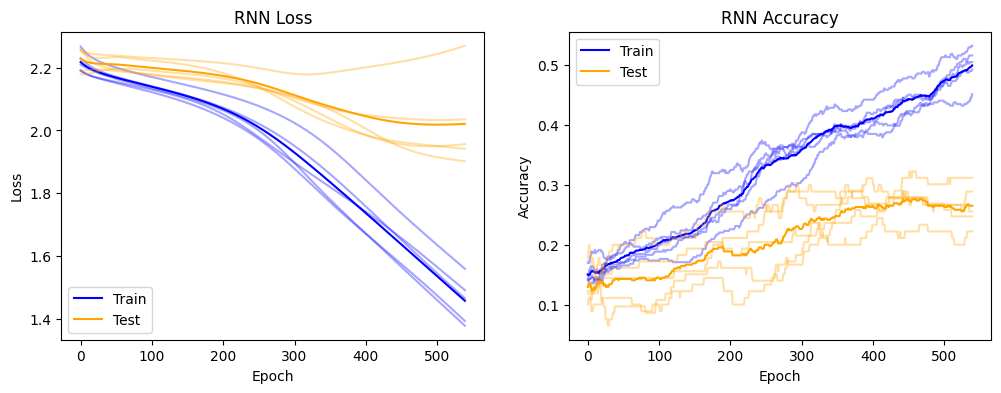

In [29]:
# from visualization.plot_model_performance import extend_history_lists

# histories = extend_history_lists(histories, epochs=epochs)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(np.array(histories['loss']).T, color='blue', alpha=0.35)
ax1.plot(np.mean(histories['loss'], axis=0), color='blue', label='Train')
ax1.plot(np.array(histories['val_loss']).T, color='orange', alpha=0.35)
ax1.plot(np.mean(histories['val_loss'], axis=0), color='orange', label='Test')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('RNN Loss')
ax1.legend()

ax2.plot(np.array(histories['accuracy']).T, color='blue', alpha=0.35)
ax2.plot(np.mean(histories['accuracy'], axis=0), color='blue', label='Train')
ax2.plot(np.array(histories['val_accuracy']).T, color='orange', alpha=0.35)
ax2.plot(np.mean(histories['val_accuracy'], axis=0), color='orange', label='Test')
# ax2.axhline(1/(n_output-1), color='gray', linestyle='--', label='Chance')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('RNN Accuracy')
ax2.legend()

plt.show()

In [ ]:
from visualization.plot_model_performance import plot_accuracy_loss

plot_accuracy_loss(histories, epochs=epochs)

In [30]:
from sklearn.metrics import balanced_accuracy_score

print('Balanced Accuracy: ', balanced_accuracy_score(y_test_all, y_pred_all))

Balanced Accuracy:  0.24490912889828134


### Transfer Training S26 -> S14

In [ ]:
# imports
from keras.optimizers import Adam
from train.transfer_training import transfer_seq2seq_kfold

In [ ]:
trans_model, trans_enc, trans_dec = lstm_1Dcnn_model(n_input_time, n_input_channel, n_output, n_filters, filter_size, n_units, reg_lambda, bidir=bidir)

In [ ]:
# parameters
num_folds = 5
batch_size = 200
# epochs = 500
learning_rate = 5e-6

trans_model.compile(optimizer=Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
models2, histories2, y_pred2_all, y_test2_all = transfer_seq2seq_kfold(trans_model, trans_enc, trans_dec, X2, X2_prior, y2, X1, X1_prior, y1, num_folds=num_folds)

In [ ]:
# from visualization.plot_model_performance import extend_history_lists

# histories = extend_history_lists(histories, epochs=epochs)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(np.array(histories2['loss']).T, color='blue', alpha=0.35)
ax1.plot(np.mean(histories2['loss'], axis=0), color='blue', label='Train')
ax1.plot(np.array(histories2['val_loss']).T, color='orange', alpha=0.35)
ax1.plot(np.mean(histories2['val_loss'], axis=0), color='orange', label='Test')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('RNN Loss')
ax1.legend()

ax2.plot(np.array(histories2['accuracy']).T, color='blue', alpha=0.35)
ax2.plot(np.mean(histories2['accuracy'], axis=0), color='blue', label='Train')
ax2.plot(np.array(histories2['val_accuracy']).T, color='orange', alpha=0.35)
ax2.plot(np.mean(histories2['val_accuracy'], axis=0), color='orange', label='Test')
# ax2.axhline(1/(n_output-1), color='gray', linestyle='--', label='Chance')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('RNN Accuracy')
ax2.legend()

plt.show()

In [ ]:
from visualization.plot_model_performance import plot_accuracy_loss

plot_accuracy_loss(histories2, epochs=540)

### Transfer Training S14 -> S33 (128 chan -> 256 chan)

In [39]:
from train.transfer_training import transfer_train_seq2seq_diff_chans

In [45]:
n_input_channel_transfer = X2.shape[2]
new_model, new_enc, new_dec = lstm_1Dcnn_model(n_input_time, n_input_channel_transfer,
                                               n_output, n_filters, filter_size, n_units,
                                               reg_lambda, bidir=bidir)
new_model.summary()

Model: "training_lstm_final"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 200, 256)]   0           []                               
                                                                                                  
 conv1d_4 (Conv1D)              (None, 20, 100)      256100      ['input_25[0][0]']               
                                                                                                  
 input_26 (InputLayer)          [(None, None, 10)]   0           []                               
                                                                                                  
 training_lstm_initial (Functio  (None, None, 10)    8369610     ['conv1d_4[0][0]',               
 nal)                                                             'input_26[0][0

In [47]:
from keras.optimizers import Adam

num_folds = 5
batch_size = 200
epochs = 540
learning_rate = 5e-4

train_model.compile(optimizer=Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
new_model.compile(optimizer=Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])